In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from readData import *
from nearNeighbors import *
from localBKG import *
from scipy import stats
from bestBkg import *
from astropy import stats
import healpy as hp

In [2]:
# Reads in data files for use in readData.py

hdulist = fits.open('/Users/mtownsend/anaconda/Data/survey-dr7-specObj-dr14.fits') # this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS AND DECALS
hdulist2 = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdulist3 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010-dr7.fits') # this is one sweep file of the DECaLS data

# hdulist = fits.open('/Users/mindy/Research/Data/lrgProjectData/survey-dr5-specObj-dr14.fits') # this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS AND DECALS
# hdulist2 = fits.open('/Users/mindy/Research/Data/lrgProjectData/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
# hdulist3 = fits.open('/Users/mindy/Research/Data/lrgProjectData/sweep-240p005-250p010.fits') # this is one sweep file of the DECaLS data


SpecObj_data = hdulist[1].data
SDSS_data = hdulist2[1].data
DECaLS_data = hdulist3[1].data

In [4]:
id_ALL, ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, gmag_BKG, zmag_BKG, color_BKG, rmag_LRG, gmag_LRG, zmag_LRG, color_LRG, z_LRG, gdepth_LRG, rdepth_LRG, zdepth_LRG, gdepth_BKG, rdepth_BKG, zdepth_BKG = readData(SpecObj_data, SDSS_data, DECaLS_data)

ra_cut_LRG = ra_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]
dec_cut_LRG = dec_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]

print("end readdata")

length of sdss array:  4851200
length of lrg only array: 1406221
length of DECaLS targets in brick:  5182673
length of id_ALL:  5182673
<class 'numpy.ndarray'>
length of id_MATCHED with LRG_cut (id_LRG): 2012
length of idcut: 5182673
length of idcut = 1 (is an LRG in DECaLS-only file): 1524
length of idcut = 0 (is not an LRG in DECaLS-only file): 5181149
length of z_lrg: 1524
end readdata


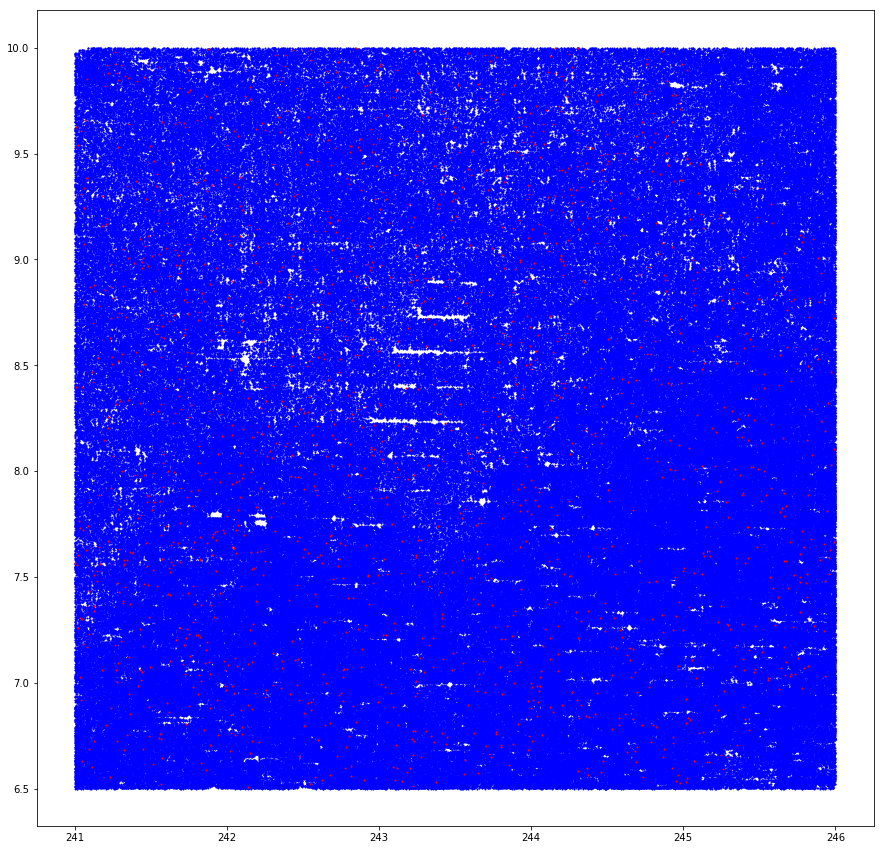

In [7]:
plt.scatter(ra_BKG, dec_BKG, s=1, color='blue')
plt.scatter(ra_LRG, dec_LRG, s=1, color='red')
plt.rcParams["figure.figsize"] = [15, 15]
plt.show()

In [8]:
DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

print("end cosmoCalc")

end cosmoCalc


In [9]:
row = 10
column = 10
# creates histogram for survey sources; excludes LRGs
H, xedges, yedges = np.histogram2d(rmag_BKG, color_BKG, normed=False)
# print("xedges: ", xedges)
# print("yedges: ", yedges)

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of sources
# divided by the area 
sd = H/(17.5) # * (3600.**2.)) # converts square degrees to square arcseconds

distance = 0.4

distance_kpc, near, gal_tree = nearNeighbor(distance, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, color_BKG, xedges, yedges)

print('end nearNeighbor')
# print(H)

end nearNeighbor


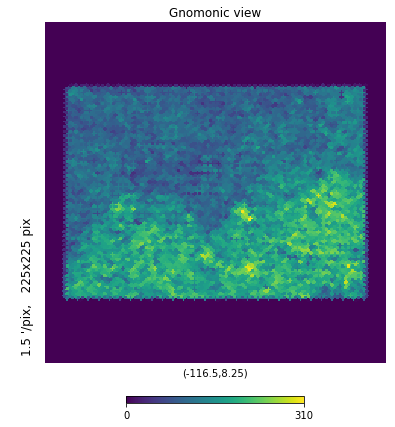

end interlopers


In [10]:
# numbkg, med_local, sigma, omega, Nbkg, r2, dist_r2, r3, dist_r3, zip_list_LRG, zip_list_BKG = localBKG_and_interlopers(distance_kpc, distance_r2, distance_r3, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, rmag_BKG, color_BKG, xedges, yedges)

min_radius = 0.4
max_radius = 1.0
nside = 1024
npixel= hp.nside2npix(nside)
ra = np.concatenate([ra_LRG, ra_BKG])
dec = np.concatenate([dec_LRG, dec_BKG])

# Using HEALPy/HEALPix to find background sources

# Make HEALPix map
# Convert ra/dec into theta/phi
theta_cut_LRG = []
phi_cut_LRG = []

for i in range(len(ra_cut_LRG)):
    theta_cut_LRG.append(np.radians(90.-dec_cut_LRG[i]))
    phi_cut_LRG.append(np.radians(ra_cut_LRG[i]))
    
theta = []
phi = []

for i in range(len(ra)):
    theta.append(np.radians(90-dec[i]))
    phi.append(np.radians(ra[i]))

    
# Convert angles theta and phi to pixel numbers
pix = hp.ang2pix(nside, theta, phi)

# Create a HEALPix map from pix
mapp = np.bincount(pix, minlength=npixel)

# Plot mapp
hp.gnomview(mapp, xsize = 225, rot=(-116.5, 8.25), flip='geo')
plt.show()

# Extracting the number of sources 
    
# Convert theta and phi to a vector
vec = hp.ang2vec(theta_cut_LRG, phi_cut_LRG, lonlat=False)

# Query_disc to find indices of pixels within a search radius
indices_min = []
indices_max = []

for i in range(len(vec)):
    indices_min.append(hp.query_disc(nside, vec[i], np.radians(min_radius)))
    indices_max.append(hp.query_disc(nside, vec[i], np.radians(max_radius)))
    
# Get arrays for sources per pixel in the search radius
temp_min0 = [] # temporary array
source_arrays_min = []

for i in range(len(indices_min)):
    for j in range(len(indices_min[i])):
        temp_min0.append(mapp[indices_min[i][j]])
    source_arrays_min.append(temp_min0)
    temp_min0 = []
    
temp_max0 = [] # temporary array
source_arrays_max = []

for i in range(len(indices_max)):
    for j in range(len(indices_max[i])):
        temp_max0.append(mapp[indices_max[i][j]])
    source_arrays_max.append(temp_max0)
    temp_max0 = []
    
# Get arrays of number of sources
temp_min1 = [] # temporary array
source_numbers_min = []

for i in range(len(source_arrays_min)):
    for j in range(len(source_arrays_min[i])):
        temp_min1.append(source_arrays_min[i][j])
        temp_min2 = np.array(temp_min1)
    source_numbers_min.append(np.sum(temp_min2))
#     source_numbers.append(len(temp2))
    temp_min1 = []
    
    
temp_max1 = [] # temporary array
source_numbers_max = []

for i in range(len(source_arrays_max)):
    for j in range(len(source_arrays_max[i])):
        temp_max1.append(source_arrays_max[i][j])
        temp_max2 = np.array(temp_max1)
    source_numbers_max.append(np.sum(temp_max2))
    temp_max1 = []
    

print("end interlopers")


In [9]:
nside = 1024
npixel= hp.nside2npix(nside)
rmag = np.concatenate([rmag_LRG, rmag_BKG])
color = np.concatenate([color_LRG, color_BKG])


# Make HEALPix map
    
# Convert angles theta and phi to pixel numbers
# pix = hp.ang2pix(nside, rmag, color)

# Create a HEALPix map from pix
mapp = np.bincount(rmag, color, minlength=npixel)

# Plot mapp
hp.gnomview(mapp, xsize = 225, rot=(-116.5, 8.25), flip='geo')
plt.show()


TypeError: Cannot cast array data from dtype('float32') to dtype('int64') according to the rule 'safe'

In [7]:
# print(len(source_arrays))
# print(len(indices))
# print(len(ra_cut_LRG))
# print(len(vec))
# print(len(theta_cut_LRG))
# print('-----')
print(source_numbers_min)
print('-----')
print(source_numbers_max)
print('-----')
print(np.array(source_numbers_max) - np.array(source_numbers_min))

[7419, 7730, 12627, 12290, 11948, 7538, 7727, 8333, 11944, 13185, 10854, 10971, 10224, 9215, 9082, 9733, 7941, 8195, 8277, 8056, 8246, 8670, 8215, 8531, 11834, 10713, 13124, 12247, 10867, 10569, 10707, 14749, 15095, 13952, 14486, 14218, 14107, 13117, 13303, 13181, 13277, 14254, 13928, 13961, 13008, 12292, 11705, 11182, 7536, 7483, 11603, 9764, 13956, 10830, 10888, 10707, 10404, 11235, 10750, 8662, 8245, 8730, 8795, 8988, 10412, 10126, 9523, 8877, 8262, 8569, 8517, 15376, 15376, 15186, 15385, 12351, 12206, 11864, 12245, 11991, 10944, 10850, 10728, 11084, 13908, 13523, 13591, 13778, 12768, 9788, 10039, 9687, 9539, 9991, 10069, 11388, 10939, 13517, 13630, 13336, 13906, 8512, 8228, 7680, 11569, 11571, 10880, 11558, 10699, 9707, 9660, 15192, 15347, 15142, 15290, 10961, 10529, 10796, 9901, 9618, 9323, 8341, 8023, 8447, 8250, 8234, 9292, 8850, 8868, 16922, 14759, 15674, 14588, 10212, 11510, 15326, 15174, 14997, 15235, 13001, 13526, 13894, 13335, 13692, 13152, 13287, 12974, 12817, 12959, 12798

In [47]:
dist_r2 = 0.4
dist_r3 = 1.0

def localBKG_and_interlopers(dist_r2, dist_r3, ra_LRG, dec_LRG, ra_BKG, dec_BKG):
    
    from sklearn.neighbors import KDTree
    import numpy as np
    
    # Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
    zip_list_LRG = list(zip(ra_LRG, dec_LRG)) # Fake LRG sources
    zip_list_BKG = list(zip(ra_BKG, dec_BKG)) # Fake EDR sources

    # Creates a tree of background sources
    gal_tree_r2 = KDTree(zip_list_BKG)

    # returns a list of background sources that are within some radius r of an LRG
    nn_r2 = gal_tree_r2.query_radius(zip_list_LRG,r=dist_r2,count_only=True)

    # find indices of near neighbors
    # creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
    # arrays could be empty
    ind_r2 = gal_tree_r2.query_radius(zip_list_LRG,r=dist_r2)
    
    # Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
    zip_list_LRG = list(zip(ra_LRG, dec_LRG)) # Fake LRG sources
    zip_list_BKG = list(zip(ra_BKG, dec_BKG)) # Fake EDR sources

    # Creates a tree of EDR sources
    gal_tree_r3 = KDTree(zip_list_BKG)

    # returns a list of EDR sources that are within some radius r of an LRG
    nn_r3 = gal_tree_r3.query_radius(zip_list_LRG,r=dist_r3,count_only=True)

    # find indices of near neighbors
    # creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
    # arrays could be empty
    ind_r3 = gal_tree_r3.query_radius(zip_list_LRG,r=dist_r3)

    annulus_ind = []

    for i in range(len(ind_r3)):
        l3 = [x for x in ind_r3[i] if x not in ind_r2[i]]
        annulus_ind.append(l3)

    # print(len(new_ind[0]))

    new_ind = np.asarray(annulus_ind)

    # number of galaxies in the annulus
    numbkg = []
    for i in range(len(new_ind)):
        numbkg.append(len(new_ind[i]))
        
    return(numbkg, nn_r2, nn_r3)

numbkg, nn_r2, nn_r3 = localBKG_and_interlopers(dist_r2, dist_r3, ra_cut_LRG, dec_cut_LRG, ra_BKG, dec_BKG)

print("end bkg")

end bkg


In [49]:
print(nn_r2)
print('-----')
print(nn_r3)
print('-----')
print(nn_r3 - nn_r2)


[ 7346  7635 12510 12216 11706  7453  7715  8182 11986 13169 10606 10594
 10094  9052  8909  9511  7571  7920  8026  7956  8104  8477  8063  8201
 11641 10669 13130 12166 10798 10486 10511 14553 14782 13765 14295 14255
 13997 13061 13222 12980 13237 14187 13865 13558 13032 12141 11490 11207
  7361  7374 11695  9640 13766 10799 10779 10524 10326 11211 10680  8296
  8059  8531  8693  8793 10208  9762  9527  8731  7936  8416  8377 15369
 15356 15055 15043 12431 12182 12015 12229 11791 10804 10700 10642 10875
 13743 13308 13400 13337 12761  9385 10017  9481  9588 10012 10033 11247
 10786 13464 13686 13079 13449  8404  8144  7607 11321 11224 10637 11225
 10166  9665  9660 15154 15259 15073 15089 10831 10386 10599  9860  9407
  9152  8202  8008  8154  8216  8046  9212  8387  8804 16352 14762 15353
 14076 10137 11245 15240 15022 14868 14939 13035 13527 13840 12856 13615
 13089 13242 12749 12945 12783 12606 11144 12109  9025 10950 10061  8918
  8096  7770 14998 15203 14929 14377 14915 15394 15

In [39]:
# kpc_DA_array = np.array(kpc_DA)

ra_cut0 = ra_LRG[np.where((z_LRG > 0.2) & (z_LRG < 0.25))]
dec_cut0 = dec_LRG[np.where((z_LRG > 0.2) & (z_LRG < 0.25))]

ra_cut1 = ra_LRG[np.where((z_LRG > 0.25) & (z_LRG < 0.3))]
dec_cut1 = dec_LRG[np.where((z_LRG > 0.25) & (z_LRG < 0.3))]

ra_cut2 = ra_LRG[np.where((z_LRG > 0.3) & (z_LRG < 0.35))]
dec_cut2 = dec_LRG[np.where((z_LRG > 0.3) & (z_LRG < 0.35))]

ra_cut3 = ra_LRG[np.where((z_LRG > 0.35) & (z_LRG < 0.4))]
dec_cut3 = dec_LRG[np.where((z_LRG > 0.35) & (z_LRG < 0.4))]

ra_cut4 = ra_LRG[np.where((z_LRG > 0.4) & (z_LRG < 0.45))]
dec_cut4 = dec_LRG[np.where((z_LRG > 0.4) & (z_LRG < 0.45))]

ra_cut5 = ra_LRG[np.where((z_LRG > 0.45) & (z_LRG < 0.5))]
dec_cut5 = dec_LRG[np.where((z_LRG > 0.45) & (z_LRG < 0.5))]

ra_cut6 = ra_LRG[np.where((z_LRG > 0.5) & (z_LRG < 0.55))]
dec_cut6 = dec_LRG[np.where((z_LRG > 0.5) & (z_LRG < 0.55))]

ra_cut7 = ra_LRG[np.where((z_LRG > 0.55) & (z_LRG < 0.6))]
dec_cut7 = dec_LRG[np.where((z_LRG > 0.55) & (z_LRG < 0.6))]

ra_cut8 = ra_LRG[np.where((z_LRG > 0.6) & (z_LRG < 0.65))]
dec_cut8 = dec_LRG[np.where((z_LRG > 0.6) & (z_LRG < 0.65))]

ra_cut9 = ra_LRG[np.where((z_LRG > 0.65) & (z_LRG < 0.7))]
dec_cut9 = dec_LRG[np.where((z_LRG > 0.65) & (z_LRG < 0.7))]


radius_max = 0.6

zip_list_LRG0 = list(zip(ra_cut0, dec_cut0))
zip_list_LRG1 = list(zip(ra_cut1, dec_cut1))
zip_list_LRG2 = list(zip(ra_cut2, dec_cut2))
zip_list_LRG3 = list(zip(ra_cut3, dec_cut3))
zip_list_LRG4 = list(zip(ra_cut4, dec_cut4))
zip_list_LRG5 = list(zip(ra_cut5, dec_cut5))
zip_list_LRG6 = list(zip(ra_cut6, dec_cut6))
zip_list_LRG7 = list(zip(ra_cut7, dec_cut7))
zip_list_LRG8 = list(zip(ra_cut8, dec_cut8))
zip_list_LRG9 = list(zip(ra_cut9, dec_cut9))

zip_list_BKG = list(zip(ra_BKG, dec_BKG))

gal_tree_outer = KDTree(zip_list_BKG)

ind_outer0 = gal_tree_outer.query_radius(zip_list_LRG0, r=radius_max)
ind_outer1 = gal_tree_outer.query_radius(zip_list_LRG1, r=radius_max)
ind_outer2 = gal_tree_outer.query_radius(zip_list_LRG2, r=radius_max)
ind_outer3 = gal_tree_outer.query_radius(zip_list_LRG3, r=radius_max)
ind_outer4 = gal_tree_outer.query_radius(zip_list_LRG4, r=radius_max)
ind_outer5 = gal_tree_outer.query_radius(zip_list_LRG5, r=radius_max)
ind_outer6 = gal_tree_outer.query_radius(zip_list_LRG6, r=radius_max)
ind_outer7 = gal_tree_outer.query_radius(zip_list_LRG7, r=radius_max)
ind_outer8 = gal_tree_outer.query_radius(zip_list_LRG8, r=radius_max)
ind_outer9 = gal_tree_outer.query_radius(zip_list_LRG9, r=radius_max)

nn_outer0, dist_outer0 = gal_tree_outer.query_radius(zip_list_LRG0, r=radius_max, return_distance=True)
nn_outer1, dist_outer1 = gal_tree_outer.query_radius(zip_list_LRG1, r=radius_max, return_distance=True)
nn_outer2, dist_outer2 = gal_tree_outer.query_radius(zip_list_LRG2, r=radius_max, return_distance=True)
nn_outer3, dist_outer3 = gal_tree_outer.query_radius(zip_list_LRG3, r=radius_max, return_distance=True)
nn_outer4, dist_outer4 = gal_tree_outer.query_radius(zip_list_LRG4, r=radius_max, return_distance=True)
nn_outer5, dist_outer5 = gal_tree_outer.query_radius(zip_list_LRG5, r=radius_max, return_distance=True)
nn_outer6, dist_outer6 = gal_tree_outer.query_radius(zip_list_LRG6, r=radius_max, return_distance=True)
nn_outer7, dist_outer7 = gal_tree_outer.query_radius(zip_list_LRG7, r=radius_max, return_distance=True)
nn_outer8, dist_outer8 = gal_tree_outer.query_radius(zip_list_LRG8, r=radius_max, return_distance=True)
nn_outer9, dist_outer9 = gal_tree_outer.query_radius(zip_list_LRG9, r=radius_max, return_distance=True)

In [6]:
radius_max = 1.0

ra_cut = ra_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]
dec_cut = dec_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]

# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_LRG = list(zip(ra_cut, dec_cut))
zip_list_BKG = list(zip(ra_BKG, dec_BKG))

# Creates a tree of EDR sources
gal_tree_outer = KDTree(zip_list_BKG)

# find indices of sources
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
ind_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max)

# returns a list of sources and their distances from the LRG within radius dist_outer
nn_outer, dist_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max, return_distance=True)

In [7]:
# radius_max = 0.4

# ra_cut = ra_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]
# dec_cut = dec_LRG[np.where((ra_LRG > 242.) & (ra_LRG < 245.) & (dec_LRG > 7.5) & (dec_LRG < 9.))]

# # Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
# zip_list_LRG = list(zip(ra_cut, dec_cut))
# zip_list_BKG = list(zip(ra_BKG, dec_BKG))

# # Creates a tree of EDR sources
# gal_tree_outer = KDTree(zip_list_BKG)

# # find indices of sources
# # creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# # arrays could be empty
# ind_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max)

# # returns a list of sources and their distances from the LRG within radius dist_outer
# nn_outer, dist_outer = gal_tree_outer.query_radius(zip_list_LRG, r=radius_max, return_distance=True)


# b = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.,16.,17.,18.,19., 20.,21.,22.,23.,24.,25.,26.,27.,28.,29.]
# b = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.] #,10.,11.,12.]
b = np.linspace(0,29.,30)

sumSigma0 = []
sumSigma1 = []
sumSigma2 = []
sumSigma3 = []
sumSigma4 = []
sumSigma5 = []
sumSigma6 = []
sumSigma7 = []
sumSigma8 = []
sumSigma9 = []
sumSigma10 = []
sumSigma11 = []
sumSigma12 = []
sumSigma13 = []
sumSigma14 = []
sumSigma15 = []
sumSigma16 = []
sumSigma17 = []
sumSigma18 = []
sumSigma19 = []
sumSigma20 = []
sumSigma21 = []
sumSigma22 = []
sumSigma23 = []
sumSigma24 = []
sumSigma25 = []
sumSigma26 = []
sumSigma27 = []
sumSigma28 = []
sumSigma29 = []
sumSigma30 = []
sumSigma31 = []
sumSigma32 = []
sumSigma33 = []
sumSigma34 = []
sumSigma35 = []
sumSigma36 = []
sumSigma37 = []
sumSigma38 = []
sumSigma39 = []
sumSigma40 = []
sumSigma41 = []
sumSigma42 = []
sumSigma43 = []
sumSigma44 = []
sumSigma45 = []
sumSigma46 = []
sumSigma47 = []
sumSigma48 = []
sumSigma49 = []

outer_radius0 = []
outer_radius1 = []
outer_radius2 = []
outer_radius3 = []
outer_radius4 = []
outer_radius5 = []
outer_radius6 = []
outer_radius7 = []
outer_radius8 = []
outer_radius9 = []
outer_radius10 = []
outer_radius11 = []
outer_radius12 = []
outer_radius13 = []
outer_radius14 = []
outer_radius15 = []
outer_radius16 = []
outer_radius17 = []
outer_radius18 = []
outer_radius19 = []
outer_radius20 = []
outer_radius21 = []
outer_radius22 = []
outer_radius23 = []
outer_radius24 = []
outer_radius25 = []
outer_radius26 = []
outer_radius27 = []
outer_radius28 = []
outer_radius29 = []
outer_radius30 = []
outer_radius31 = []
outer_radius32 = []
outer_radius33 = []
outer_radius34 = []
outer_radius35 = []
outer_radius36 = []
outer_radius37 = []
outer_radius38 = []
outer_radius39 = []
outer_radius40 = []
outer_radius41 = []
outer_radius42 = []
outer_radius43 = []
outer_radius44 = []
outer_radius45 = []
outer_radius46 = []
outer_radius47 = []
outer_radius48 = []
outer_radius49 = []

inner_radius0 = []
inner_radius1 = []
inner_radius2 = []
inner_radius3 = []
inner_radius4 = []
inner_radius5 = []
inner_radius6 = []
inner_radius7 = []
inner_radius8 = []
inner_radius9 = []
inner_radius10 = []
inner_radius11 = []
inner_radius12 = []
inner_radius13 = []
inner_radius14 = []
inner_radius15 = []
inner_radius16 = []
inner_radius17 = []
inner_radius18 = []
inner_radius19 = []
inner_radius20 = []
inner_radius21 = []
inner_radius22 = []
inner_radius23 = []
inner_radius24 = []
inner_radius25 = []
inner_radius26 = []
inner_radius27 = []
inner_radius28 = []
inner_radius29 = []
inner_radius30 = []
inner_radius31 = []
inner_radius32 = []
inner_radius33 = []
inner_radius34 = []
inner_radius35 = []
inner_radius36 = []
inner_radius37 = []
inner_radius38 = []
inner_radius39 = []
inner_radius40 = []
inner_radius41 = []
inner_radius42 = []
inner_radius43 = []
inner_radius44 = []
inner_radius45 = []
inner_radius46 = []
inner_radius47 = []
inner_radius48 = []
inner_radius49 = []

sumbkg0 = []
sumbkg1 = []
sumbkg2 = []
sumbkg3 = []
sumbkg4 = []
sumbkg5 = []
sumbkg6 = []
sumbkg7 = []
sumbkg8 = []
sumbkg9 = []
sumbkg10 = []
sumbkg11 = []
sumbkg12 = []
sumbkg13 = []
sumbkg14 = []
sumbkg15 = []
sumbkg16 = []
sumbkg17 = []
sumbkg18 = []
sumbkg19 = []
sumbkg20 = []
sumbkg21 = []
sumbkg22 = []
sumbkg23 = []
sumbkg24 = []
sumbkg25 = []
sumbkg26 = []
sumbkg27 = []
sumbkg28 = []
sumbkg29 = []
sumbkg30 = []
sumbkg31 = []
sumbkg32 = []
sumbkg33 = []
sumbkg34 = []
sumbkg35 = []
sumbkg36 = []
sumbkg37 = []
sumbkg38 = []
sumbkg39 = []
sumbkg40 = []
sumbkg41 = []
sumbkg42 = []
sumbkg43 = []
sumbkg44 = []
sumbkg45 = []
sumbkg46 = []
sumbkg47 = []
sumbkg48 = []
sumbkg49 = []

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
error5 = []
error6 = []
error7 = []
error8 = []
error9 = []
error10 = []
error11 = []
error12 = []
error13 = []
error14 = []
error15 = []
error16 = []
error17 = []
error18 = []
error19 = []
error20 = []
error21 = []
error22 = []
error23 = []
error24 = []
error25 = []
error26 = []
error27 = []
error28 = []
error29 = []
error30 = []
error31 = []
error32 = []
error33 = []
error34 = []
error35 = []
error36 = []
error37 = []
error38 = []
error39 = []
error40 = []
error41 = []
error42 = []
error43 = []
error44 = []
error45 = []
error46 = []
error47 = []
error48 = []
error49 = []

sigma0 = []
sigma1 = []
sigma2 = []
sigma3 = []
sigma4 = []
sigma5 = []
sigma6 = []
sigma7 = []
sigma8 = []
sigma9 = []
sigma10 = []
sigma11 = []
sigma12 = []
sigma13 = []
sigma14 = []
sigma15 = []
sigma16 = []
sigma17 = []
sigma18 = []
sigma19 = []
sigma20 = []
sigma21 = []
sigma22 = []
sigma23 = []
sigma24 = []
sigma25 = []
sigma26 = []
sigma27 = []
sigma28 = []
sigma29 = []
sigma30 = []
sigma31 = []
sigma32 = []
sigma33 = []
sigma34 = []
sigma35 = []
sigma36 = []
sigma37 = []
sigma38 = []
sigma39 = []
sigma40 = []
sigma41 = []
sigma42 = []
sigma43 = []
sigma44 = []
sigma45 = []
sigma46 = []
sigma47 = []
sigma48 = []
sigma49 = []

area0 = []
area1 = []
area2 = []
area3 = []
area4 = []
area5 = []
area6 = []
area7 = []
area8 = []
area9 = []
area10 = []
area11 = []
area12 = []
area13 = []
area14 = []
area15 = []
area16 = []
area17 = []
area18 = []
area19 = []
area20 = []
area21 = []
area22 = []
area23 = []
area24 = []
area25 = []
area26 = []
area27 = []
area28 = []
area29 = []
area30 = []
area31 = []
area32 = []
area33 = []
area34 = []
area35 = []
area36 = []
area37 = []
area38 = []
area39 = []
area40 = []
area41 = []
area42 = []
area43 = []
area44 = []
area45 = []
area46 = []
area47 = []
area48 = []
area49 = []

sumSigma = [sumSigma0, sumSigma1, sumSigma2, sumSigma3, sumSigma4, sumSigma5, sumSigma6, sumSigma7, sumSigma8, sumSigma9, sumSigma10, sumSigma11, sumSigma12, sumSigma13, sumSigma14, sumSigma15, sumSigma16, sumSigma17, sumSigma18, sumSigma19, sumSigma20, sumSigma21, sumSigma22, sumSigma23, sumSigma24, sumSigma25, sumSigma26, sumSigma27, sumSigma28, sumSigma29, sumSigma30, sumSigma31, sumSigma32, sumSigma33, sumSigma34, sumSigma35, sumSigma36, sumSigma37, sumSigma38, sumSigma39, sumSigma40, sumSigma41, sumSigma42, sumSigma43, sumSigma44, sumSigma45, sumSigma46, sumSigma47, sumSigma48, sumSigma49] 
outer_radius = [outer_radius0, outer_radius1, outer_radius2, outer_radius3, outer_radius4, outer_radius5, outer_radius6, outer_radius7, outer_radius8, outer_radius9, outer_radius10, outer_radius11, outer_radius12, outer_radius13, outer_radius14, outer_radius15, outer_radius16, outer_radius17, outer_radius18, outer_radius19, outer_radius20, outer_radius21, outer_radius22, outer_radius23, outer_radius24, outer_radius25, outer_radius26, outer_radius27, outer_radius28, outer_radius29, outer_radius30, outer_radius31, outer_radius32, outer_radius33, outer_radius34, outer_radius35, outer_radius36, outer_radius37, outer_radius38, outer_radius39, outer_radius40, outer_radius41, outer_radius42, outer_radius43, outer_radius44, outer_radius45, outer_radius46, outer_radius47, outer_radius48, outer_radius49]
inner_radius = [inner_radius0, inner_radius1, inner_radius2, inner_radius3, inner_radius4, inner_radius5, inner_radius6, inner_radius7, inner_radius8, inner_radius9, inner_radius10, inner_radius11, inner_radius12, inner_radius13, inner_radius14, inner_radius15, inner_radius16, inner_radius17, inner_radius18, inner_radius19, inner_radius20, inner_radius21, inner_radius22, inner_radius23, inner_radius24, inner_radius25, inner_radius26, inner_radius27, inner_radius28, inner_radius29, inner_radius30, inner_radius31, inner_radius32, inner_radius33, inner_radius34, inner_radius35, inner_radius36, inner_radius37, inner_radius38, inner_radius39, inner_radius40, inner_radius41, inner_radius42, inner_radius43, inner_radius44, inner_radius45, inner_radius46, inner_radius47, inner_radius48, inner_radius49]
sumbkg = [sumbkg0, sumbkg1, sumbkg2, sumbkg3, sumbkg4, sumbkg5, sumbkg6, sumbkg7, sumbkg8, sumbkg9, sumbkg10, sumbkg11, sumbkg12, sumbkg13, sumbkg14, sumbkg15, sumbkg16, sumbkg17, sumbkg18, sumbkg19, sumbkg20, sumbkg21, sumbkg22, sumbkg23, sumbkg24, sumbkg25, sumbkg26, sumbkg27, sumbkg28, sumbkg29, sumbkg30, sumbkg31, sumbkg32, sumbkg33, sumbkg34, sumbkg35, sumbkg36, sumbkg37, sumbkg38, sumbkg39, sumbkg40, sumbkg41, sumbkg42, sumbkg43, sumbkg44, sumbkg45, sumbkg46, sumbkg47, sumbkg48, sumbkg49]
error = [error0, error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, error11, error12, error13, error14, error15, error16, error17, error18, error19, error20, error21, error22, error23, error24, error25, error26, error27, error28, error29, error30, error31, error32, error33, error34, error35, error36, error37, error38, error39, error40, error41, error42, error43, error44, error45, error46, error47, error48, error49]
sigma = [sigma0, sigma1, sigma2, sigma3, sigma4, sigma5, sigma6, sigma7, sigma8, sigma9, sigma10, sigma11, sigma12, sigma13, sigma14, sigma15, sigma16, sigma17, sigma18, sigma19, sigma20, sigma21, sigma22, sigma23, sigma24, sigma25, sigma26, sigma27, sigma28, sigma29, sigma30, sigma31, sigma32, sigma33, sigma34, sigma35, sigma36, sigma37, sigma38, sigma39, sigma40, sigma41, sigma42, sigma43, sigma44, sigma45, sigma46, sigma47, sigma48, sigma49]
area = [area0, area1, area2, area3, area4, area5, area6, area7, area8, area9, area10, area11, area12, area13, area14, area15, area16, area17, area18, area19, area20, area21, area22, area23, area24, area25, area26, area27, area28, area29, area30, area31, area32, area33, area34, area35, area36, area37, area38, area39, area40, area41, area42, area43, area44, area45, area46, area47, area48, area49]

sumSigma_dict = dict(enumerate(sumSigma))
outerradius_dict = dict(enumerate(outer_radius))
innerradius_dict = dict(enumerate(inner_radius))
sumbkg_dict = dict(enumerate(sumbkg))
error_dict = dict(enumerate(error))
sigma_dict = dict(enumerate(sigma))
area_dict = dict(enumerate(area))

for i in range(len(ind_outer)):
    for j in range(len(b)):
        result = bestBKG(30., b[j], dist_outer[i], ind_outer[i], radius_max, xedges, yedges, rmag_BKG, color_BKG)
        sumSigma_dict[j].append(result[0])
        outerradius_dict[j].append(result[1]) 
        innerradius_dict[j].append(result[2])
        sumbkg_dict[j].append(result[3])
        error_dict[j].append(result[4]) 
        sigma_dict[j].append(result[5]) 
        area_dict[j].append(result[6]) 
        
print('end bestBKG')

end bestBKG


In [8]:

# error = []
# sig = []
# area = []

# for m in range(len(b)):
#     for n in range(len(ra_cut)):
#         sig.append(sumSigma_dict[m][n])
#         area.append(area_dict[m][n])
#         error.append(np.sqrt(sumSigma_dict[m][n])/area_dict[m][n])
    
# arr = np.asarray(error)
# print(arr.shape)

# print(sig)
# print('-----')
# print(area)


# Creates error_list, a list of lists of poisson errors for each radius. One list per LRG. Each of those lists
# has a poisson error value for each radius.

error = []
error_list = []
sig = []
area = []

for n in range(len(ra_cut)):
    for m in range(len(b)):
        sig.append(sumSigma_dict[m][n])
        area.append(area_dict[m][n])
        error.append(np.sqrt(sumSigma_dict[m][n])/area_dict[m][n])
    error_list.append(error)
#     print('sig is', sig)
#     print('----')
#     print('area is', area)
#     print('----')
#     print('error_list is', error_list)
#     print('----')
    error = []
    sig = []
    area = []

# print(error_list[0])
# print(error_list[1])
# print(error_list[2])
# print(error_list[3])
# print(error_list[4])

arr = np.asarray(error_list)
print(arr.shape)

(306, 30)


#### dict[annulus][LRG] 

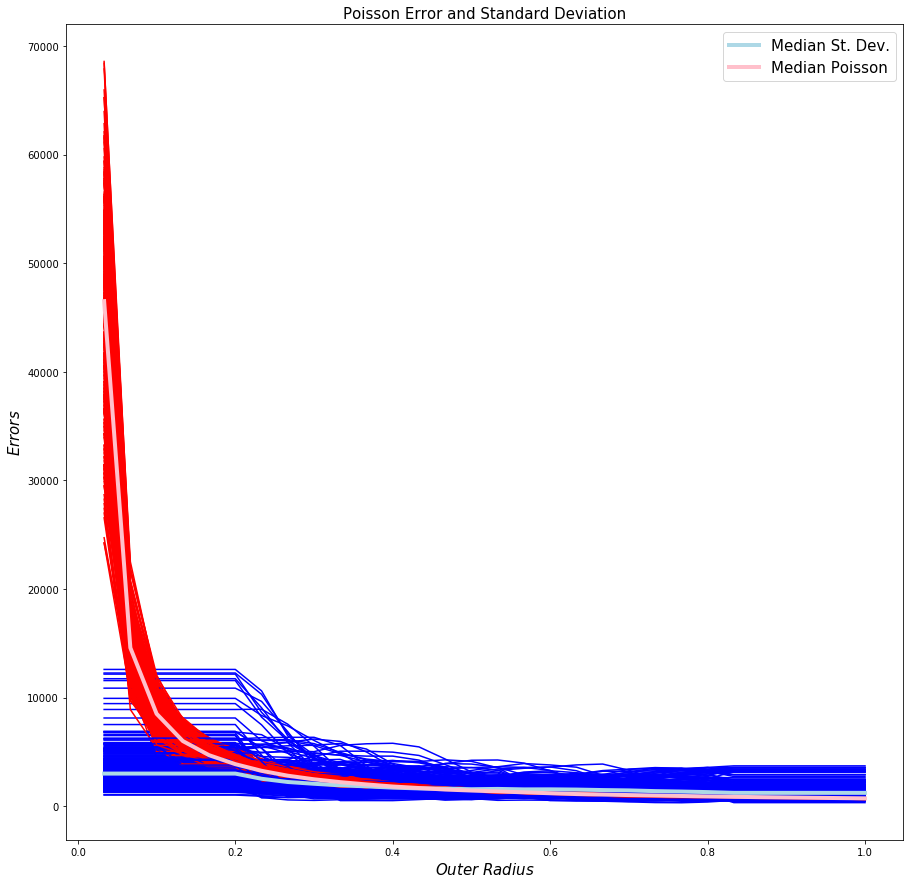

In [10]:
# m = annulus
# n = LRG
# z is array of standard deviations because I'm bad at planning variables.

# n = 0
z = []
stdevs = []

for n in range(len(ra_cut)): 
    for m in range(len(b)):
    # conditions for first 5 points
        if m == 0:
            a = np.array([sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n], sumSigma_dict[m+4][n], sumSigma_dict[m+5][n], sumSigma_dict[m+6][n], sumSigma_dict[m+7][n], sumSigma_dict[m+8][n], sumSigma_dict[m+9][n], sumSigma_dict[m+10][n]])
            z.append(np.std(a))
        elif m == 1:
            a = np.array([sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n], sumSigma_dict[m+4][n], sumSigma_dict[m+5][n], sumSigma_dict[m+6][n], sumSigma_dict[m+7][n], sumSigma_dict[m+8][n], sumSigma_dict[m+9][n]])
            z.append(np.std(a))
        elif m == 2:
            a = np.array([sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n], sumSigma_dict[m+4][n], sumSigma_dict[m+5][n], sumSigma_dict[m+6][n], sumSigma_dict[m+7][n], sumSigma_dict[m+8][n]])
            z.append(np.std(a))
        elif m == 3:
            a = np.array([sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n], sumSigma_dict[m+4][n], sumSigma_dict[m+5][n], sumSigma_dict[m+6][n], sumSigma_dict[m+7][n]])
            z.append(np.std(a))
        elif m == 4:
            a = np.array([sumSigma_dict[m-4][n], sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n], sumSigma_dict[m+4][n], sumSigma_dict[m+5][n], sumSigma_dict[m+6][n]])
            z.append(np.std(a))
        
    # conditions for last 5 points
        elif m == 25:
            a = np.array([sumSigma_dict[m-6][n], sumSigma_dict[m-5][n], sumSigma_dict[m-4][n], sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n], sumSigma_dict[m+4][n]])
            z.append(np.std(a))
        elif m == 26:
            a = np.array([sumSigma_dict[m-7][n], sumSigma_dict[m-6][n], sumSigma_dict[m-5][n], sumSigma_dict[m-4][n], sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n]])
            z.append(np.std(a))
        elif m == 27:
            a = np.array([sumSigma_dict[m-8][n], sumSigma_dict[m-7][n], sumSigma_dict[m-6][n], sumSigma_dict[m-5][n], sumSigma_dict[m-4][n], sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n]])
            z.append(np.std(a))
        elif m == 28:
            a = np.array([sumSigma_dict[m-9][n], sumSigma_dict[m-8][n], sumSigma_dict[m-7][n], sumSigma_dict[m-6][n], sumSigma_dict[m-5][n], sumSigma_dict[m-4][n], sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n]])
            z.append(np.std(a))
        elif m == 29:
            a = np.array([sumSigma_dict[m-10][n], sumSigma_dict[m-9][n], sumSigma_dict[m-8][n], sumSigma_dict[m-7][n], sumSigma_dict[m-6][n], sumSigma_dict[m-5][n], sumSigma_dict[m-4][n], sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n]])
            z.append(np.std(a))
        
    # condition for all points in between the first and last 5
        elif (m > 4) & (m < 25):
            a = np.array([sumSigma_dict[m-5][n], sumSigma_dict[m-4][n], sumSigma_dict[m-3][n], sumSigma_dict[m-2][n], sumSigma_dict[m-1][n], sumSigma_dict[m][n], sumSigma_dict[m+1][n], sumSigma_dict[m+2][n], sumSigma_dict[m+3][n], sumSigma_dict[m+4][n], sumSigma_dict[m+5][n]])
            z.append(np.std(a))
    stdevs.append(z)
#     print('z is', z)
#     print('----')
#     print('stdevs is', stdevs)
    z = []


outer_temp = []
median_stdev = []
median_poisson = []
for k in range(len(b)):
#     error_temp.append(error_dict[k][n])
    outer_temp.append(outerradius_dict[k][0])
#         print(sumSig_temp)
#         print(outer_temp)
#         print('------')

# error_temp_array = np.asarray(error_temp)
outer_temp_array = np.asarray(outer_temp)

# print(error_temp_array.shape)
# print(outer_temp_array.shape)

for i in range(len(stdevs)):
    plt.plot(outer_temp, stdevs[i], c='b') # label='St.Dev.')
    plt.plot(outer_temp, error_list[i], c='r') # label='Poisson')
#     plt.legend(loc="upper right", fontsize = 15)

perror = []
serror = []
for j in range(len(b)):
    for i in range(len(ra_cut)):
        perror.append(error_list[i][j])
        serror.append(stdevs[i][j])
    median_poisson.append(np.median(perror))
    median_stdev.append(np.median(serror))
    perror = []
    serror = []
    

plt.plot(outer_temp, median_stdev, c='lightblue', label='Median St. Dev.', linewidth=4)
plt.plot(outer_temp, median_poisson, c='pink', label='Median Poisson', linewidth=4)    
plt.rcParams["figure.figsize"] = [15, 15]
plt.title("Poisson Error and Standard Deviation", fontsize=15)
plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
plt.ylabel(r'$Errors$', fontsize=15)  
plt.legend(loc="upper right", fontsize = 15)
    
plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/error_plot_median.pdf")
plt.show()


# stdev = []
# z = []
# for i in range(len(ra_cut)):
#     for j in range(len(b)-6):
#         a = np.array([sumSigma_dict[j][i], sumSigma_dict[j+1][i], sumSigma_dict[j+2][i], sumSigma_dict[j+3][i], sumSigma_dict[j+4][i], sumSigma_dict[j+5][i], sumSigma_dict[j+6][i]])
#         z.append(np.std(a))
# #         print(len(z))        
#     stdev.append([z])
#     z = []
    
# # print('--------')
# print(stdev[0])
# print('--------')
# print(stdev[1])
# print('--------')
# # print(stdev)
# # print(len(stdev[0]))

# # sumSig_temp = []
# outer_temp = []
# error_temp = []
# for i in range(len(ra_cut)):
#     for j in range(len(b)):
#         outer_temp.append(outerradius_dict[j][i])
#         error_temp.append(error[j][i])
# #         print(sumSig_temp)
# #         print(outer_temp)
# #         print('------')
#         plt.plot(outer_temp, error_temp) #, marker='o')
# #         plt.errorbar(outer_temp, sumSig_temp, yerr = error_temp, fmt='o', ecolor='red')
#     outer_temp = []
#     error_temp = []

# plt.rcParams["figure.figsize"] = [15, 15]
# plt.title("Poisson Error vs. Outer Radius", fontsize=15)
# plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
# plt.ylabel(r'$Poisson$ $Error$', fontsize=15)    
    
# plt.show()


    

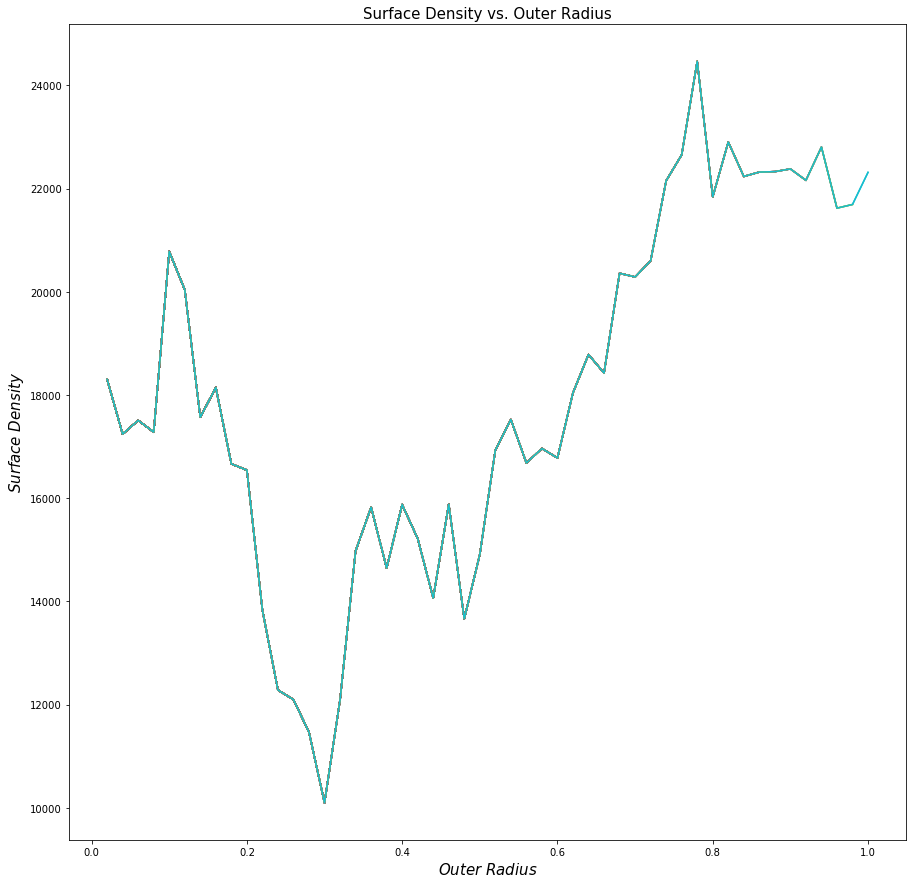

In [14]:
sumSig_temp = []
outer_temp = []
# error_temp = []

for j in range(len(b)):
    sumSig_temp.append(sumSigma_dict[j][0])
    outer_temp.append(outerradius_dict[j][0])
#         error_temp.append(error[j][i])
#         print(sumSig_temp)
#         print(outer_temp)
#         print('------')
    plt.plot(outer_temp, sumSig_temp) #, marker='o')
#         plt.errorbar(outer_temp, sumSig_temp, yerr = error_temp, fmt='o', ecolor='red')
sumSig_temp = []
outer_temp = []
#     error_temp = []
    
plt.rcParams["figure.figsize"] = [15, 15]
plt.title("Surface Density vs. Outer Radius", fontsize=15)
plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
plt.ylabel(r'$Surface$ $Density$', fontsize=15)

plt.show()

306
306
306


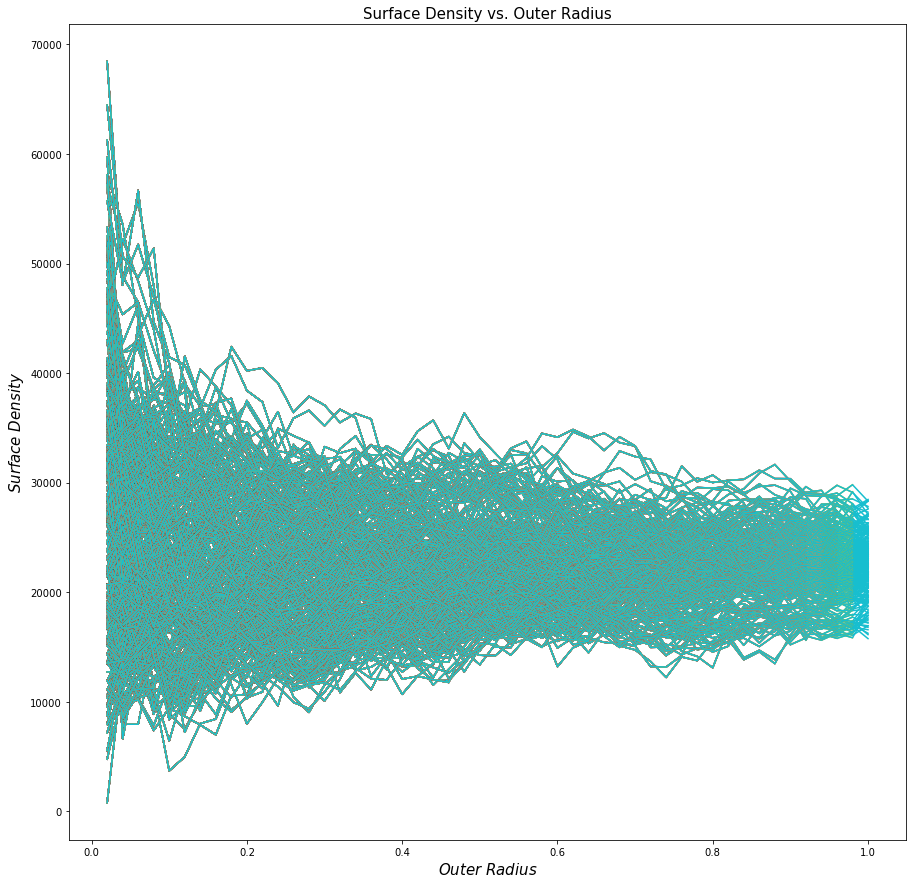

In [15]:
# print(sumSigma_dict[9][0])
# print(sumSigma_dict[9])
print(len(error_dict[1]))
print(len(sumSigma_dict[1]))
print(len(outerradius_dict[1]))

# plt.xkcd()

sumSig_temp = []
outer_temp = []
# error_temp = []

for i in range(len(ra_cut)):
    for j in range(len(b)):
        sumSig_temp.append(sumSigma_dict[j][i])
        outer_temp.append(outerradius_dict[j][i])
#         error_temp.append(error[j][i])
#         print(sumSig_temp)
#         print(outer_temp)
#         print('------')
        plt.plot(outer_temp, sumSig_temp) #, marker='o')
#         plt.errorbar(outer_temp, sumSig_temp, yerr = error_temp, fmt='o', ecolor='red')
    sumSig_temp = []
    outer_temp = []
#     error_temp = []
    
plt.rcParams["figure.figsize"] = [15, 15]
plt.title("Surface Density vs. Outer Radius", fontsize=15)
plt.xlabel(r'$Outer$ $Radius$', fontsize=15)
plt.ylabel(r'$Surface$ $Density$', fontsize=15)

plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/sd_v_radius1deg.pdf")

plt.show()
        

In [7]:
Nsat = np.array(near) - np.array(Nbkg)
print("end Nsat")

end Nsat


In [8]:
sumsat, sumsat1z, sumsat2z, sumsat3z, sumsat4z, sumsat5z, sumsat6z, sumsat7z, sumsat1r, sumsat2r, sumsat3r, sumsat4r, sumsat5r, sumsat6r, sumsat7r, sumsat1g, sumsat2g, sumsat3g, sumsat4g, sumsat5g, sumsat6g, sumsat7g, sumsat8g, sumsat1_zmag, sumsat2_zmag, sumsat3_zmag, sumsat4_zmag, sumsat5_zmag, sumsat6_zmag, sumsat7_zmag  = sumNsat(Nsat, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

sumnear, sumnear1z, sumnear2z, sumnear3z, sumnear4z, sumnear5z, sumnear6z, sumnear7z, sumnear1r, sumnear2r, sumnear3r, sumnear4r, sumnear5r, sumnear6r, sumnear7r, sumnear1g, sumnear2g, sumnear3g, sumnear4g, sumnear5g, sumnear6g, sumnear7g, sumnear8g, sumnear1_zmag, sumnear2_zmag, sumnear3_zmag, sumnear4_zmag, sumnear5_zmag, sumnear6_zmag, sumnear7_zmag = sumNN(near, z_LRG, rmag_LRG, gmag_LRG, zmag_LRG)

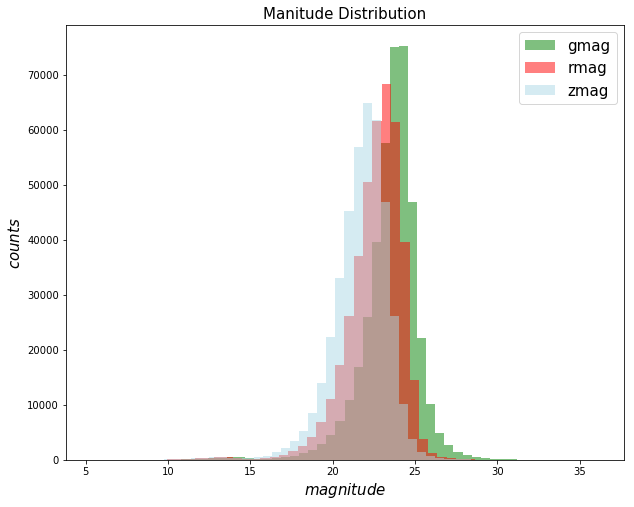

In [15]:
magHist(gmag_BKG, rmag_BKG, zmag_BKG)
plt.show()

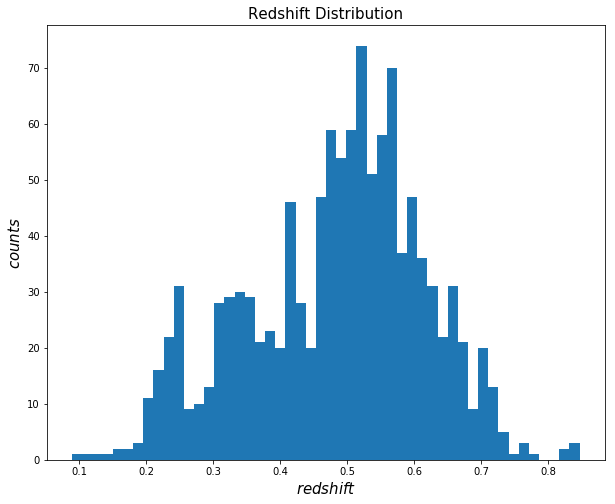

In [16]:
zHist(z_LRG)
plt.show()

mean number of satellites is 16.393863307269044
median number of satellites is 14.27
standard deviation of satellites is 26.05054032751309
standard error is 0.7681885249561131


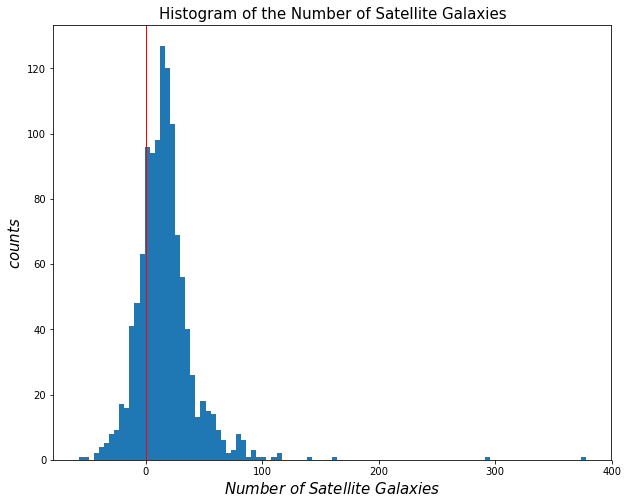

In [33]:
from lrg_plot_functions import *
totalNsat(Nsat)
plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/NsatHist.pdf")
# plt.savefig("/Users/mindy/Research/Plots/LRG_Project_Plots/NsatHist.pdf")
plt.show()

mean number of interlopers is 41.82507674485954
median number of interlopers is 35.17333333333334
standard deviation of interloper is 26.290921583497664
standard error is 0.7752769814771803


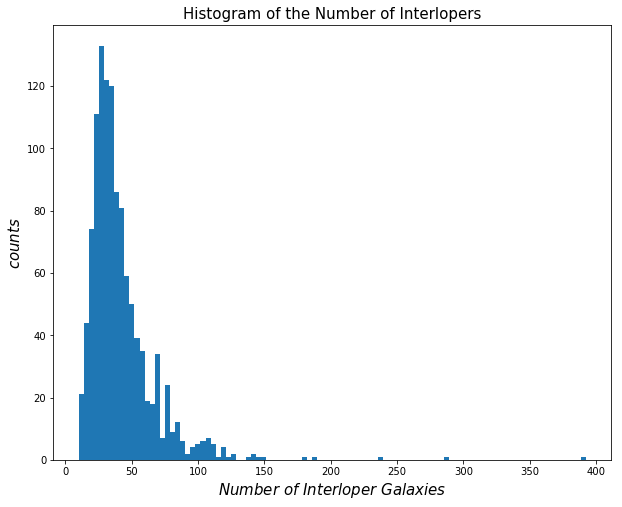

In [9]:
totalNbkg(Nbkg)

plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/bkgHist.pdf")

plt.show()

mean number of near neighbors is 58.21894005212858
median number of near neighbors is 50.0
standard deviation of near neighbor is 42.82393619172537
standard error is 1.262808984472097


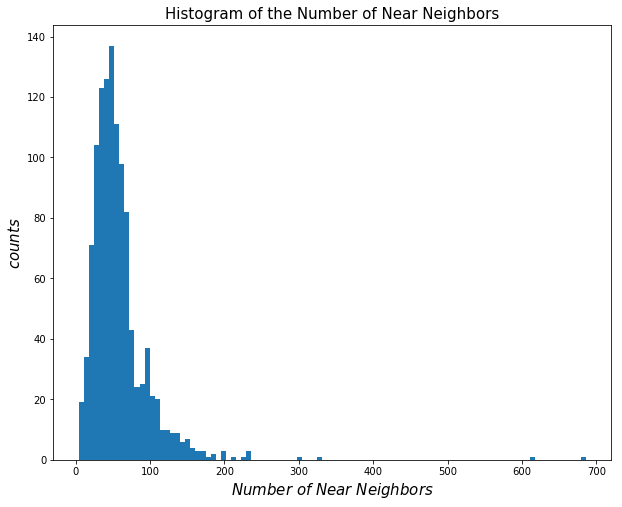

In [11]:
totalNear(near)

plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/nearHist.pdf")

plt.show()

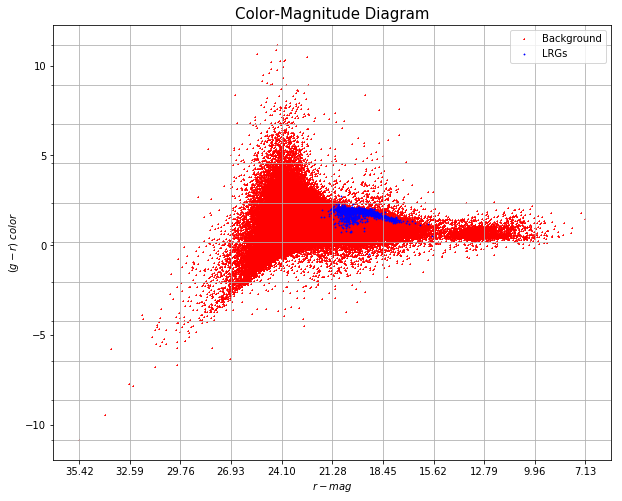

In [20]:
cmd(rmag_BKG, color_BKG, rmag_LRG, color_LRG, xedges, yedges)
plt.show()

The median of Nsat: 14.27
The median of bootmed: 14.27
Low 68% confidence interval: 13.770000000000012
High 68% confidence interval: 14.693333333333339


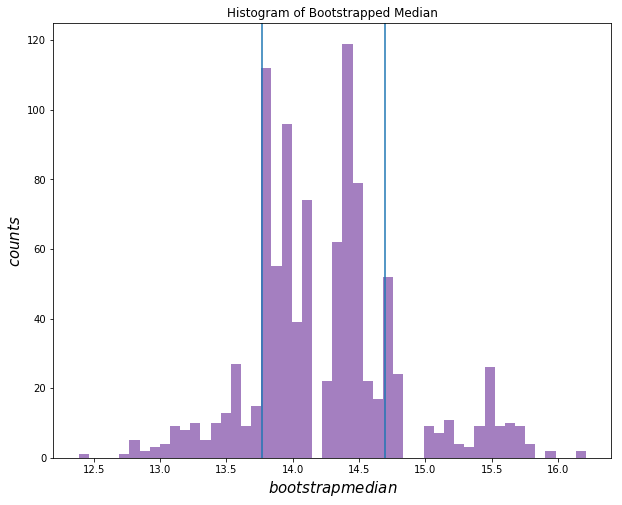

In [12]:
boot_med_plot(1000, 0.68, np.median, sumsat)
plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/boothist.pdf")
plt.show()

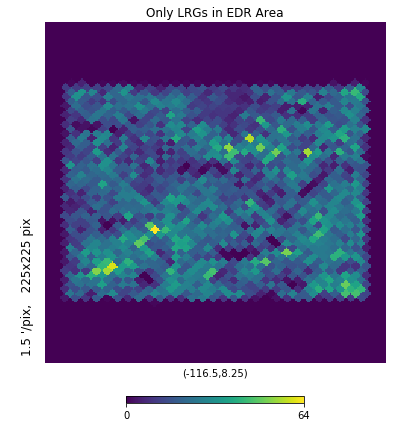

In [9]:
from lrg_plot_functions import *
healpix(ra_BKG, dec_BKG, ra_LRG, dec_LRG, gmag_BKG, rmag_BKG, zmag_BKG)
# plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/healpix1.pdf")
plt.savefig("/Users/mtownsend/anaconda/GitHub/lrg-project/Plots/LRG_science_plots/healpix2.pdf")
plt.show()

mean number of satellites at z < 0.2: 93.27791666666667
mean number of satellites at 0.2 <= z < 0.3: 30.168773584905658
mean number of satellites at 0.3 <= z < 0.4: 20.667899807321774
mean number of satellites at 0.4 <= z < 0.5: 14.227852684144821
mean number of satellites at 0.5 <= z < 0.6: 12.231111111111112
mean number of satellites at 0.6 <= z < 0.7: 11.110119760479044
mean number of satellites at z < 0.7: 7.0530081300813015
total number of Nsat arrays: 1151


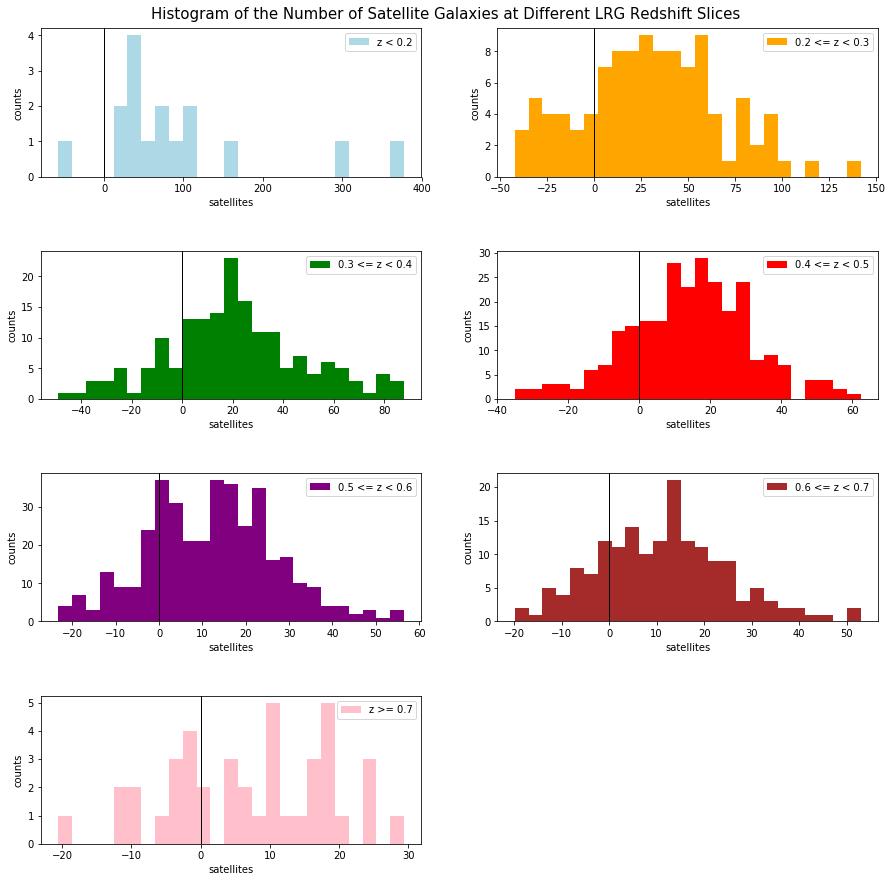

In [13]:
z_cut_Nsat(z_LRG, Nsat)

plt.savefig("/Users/mindy/Research/Plots/LRG_Project_Plots/Nsat_z_hist.pdf")

plt.show()